# Training a neural network
## Basic feed forward + back propagation model
### Activate layer
First, we need to activate each layer. We will later need the pre-activation values for each node to implement the back propagation, so we add the option to save those as well.

In [1]:
import jax.numpy as jnp
from jax import nn


def activate_layer(input, weight, bias, activation="relu", return_preactivation=False):
    """
    Apply single layer transformation with specified activation function.

    Args:
        input: Input vector or batch
        weight: Weight matrix for the layer
        bias: Bias vector for the layer
        activation: Activation function name (default: "relu")
        return_preactivation: If True, return both pre and post activation values

    Returns:
        If return_preactivation=False: Activated layer output
        If return_preactivation=True: Tuple of (pre_activation, activated_output)

    Raises:
        ValueError: If activation function is not supported
    """
    # Validate dimensional compatibility between weights and inputs
    if weight.shape[1] != input.shape[-1]:
        raise ValueError(
            f"Weight shape {weight.shape} incompatible with input shape {input.shape}"
        )
    if weight.shape[0] != bias.shape[0]:
        raise ValueError(
            f"Weight output size {weight.shape[0]} doesn't match bias size {bias.shape[0]}"
        )

    # Compute linear transformation: z = xW^T + b (batch-first convention)
    z = jnp.dot(input, weight.T) + bias

    # Apply specified activation function using JAX neural network functions
    if activation == "linear":
        a = z
    elif activation == "tanh":
        a = nn.tanh(z)
    elif activation == "sigmoid":
        a = nn.sigmoid(z)
    elif activation == "relu":
        a = nn.relu(z)
    else:
        raise ValueError(f"Unsupported activation type: {activation}")

    # Return based on preactivation flag
    if not return_preactivation:
        return a
    else:
        return (z, a)

### Forward pass
The forward pass replaces the activate network function. Since we will later need the pre-activation values, we keep a cache here to track those and return it in the end.

In [2]:
def forward_pass(input_batch, weights, biases, activation="relu"):
    """
    Perform forward pass through network with intermediate value caching.

    Args:
        input_batch: Input data for the network
        weights: List of weight matrices for each layer
        biases: List of bias vectors for each layer
        activation: Activation function name (default: "relu")

    Returns:
        Tuple of (final_output, cache) where cache contains intermediate values
        for backpropagation: layer inputs, pre-activations, and post-activations

    Raises:
        ValueError: If number of weights and biases don't match
    """
    # Initialize cache to store intermediate values for backpropagation
    cache = {
        "z_values": [],  # Pre-activation values z = xW^T + b for each layer
        "activations": [],  # Post-activation values a(z) for each layer
        "layer_inputs": [],  # Input to each layer (for gradient computation)
    }

    # Validate network architecture consistency
    num_layers = len(weights)
    if num_layers != len(biases):
        raise ValueError("The number of weight matrices and bias vectors do not match.")

    # Propagate through network layers while caching intermediate results
    current_input = input_batch
    for weight, bias in zip(weights, biases):
        # Compute both pre and post activation values
        z, a = activate_layer(
            current_input, weight, bias, activation, return_preactivation=True
        )

        # Cache values needed for backpropagation
        cache["layer_inputs"].append(current_input)
        cache["z_values"].append(z)
        cache["activations"].append(a)

        # Update input for next layer
        current_input = a

    return (current_input, cache)

### Derivatives of activation functions

In [3]:
import jax.numpy as jnp
from jax import nn


def activation_dv(z, activation="relu"):
    """
    Compute derivative of activation function with respect to pre-activation.

    Args:
        z: Pre-activation values
        activation: Activation function name (default: "relu")

    Returns:
        Derivative values of the activation function

    Raises:
        ValueError: If activation function is not supported
    """
    # Compute activation function derivatives for backpropagation
    if activation == "linear":
        return jnp.ones_like(z)
    elif activation == "tanh":
        # Tanh derivative: 1 - tanh²(z)
        tanh_z = nn.tanh(z)
        return 1 - tanh_z**2
    elif activation == "sigmoid":
        # Sigmoid derivative: σ(z) * (1 - σ(z))
        sig = nn.sigmoid(z)
        return sig * (1 - sig)
    elif activation == "relu":
        # ReLU derivative: 1 if z > 0, else 0
        return (z > 0).astype(float)
    else:
        raise ValueError(f"Unsupported activation type: {activation}")

### Loss function and its derivative

In [4]:
import jax.numpy as jnp


def loss_fn(predictions, targets, loss_type="mse"):
    """
    Compute loss between predictions and targets.

    Args:
        predictions: Model predictions
        targets: Ground truth target values
        loss_type: Type of loss function ("mse" or "mae", default: "mse")

    Returns:
        Scalar loss value

    Raises:
        ValueError: If loss type is not supported
    """
    # Validate dimensional consistency between predictions and targets
    if predictions.shape != targets.shape:
        raise ValueError(
            f"Predictions shape {predictions.shape} doesn't match targets shape {targets.shape}"
        )

    # Compute specified loss function
    if loss_type == "mae":
        # Mean Absolute Error: L1 loss
        return jnp.mean(jnp.abs(predictions - targets))
    elif loss_type == "mse":
        # Mean Squared Error: L2 loss with 1/2 scaling for cleaner gradients
        return jnp.mean((predictions - targets) ** 2) / 2
    else:
        raise ValueError(f"Unsupported loss type: {loss_type}")


def loss_dv(predictions, targets, loss_type="mse"):
    """
    Compute derivative of loss function with respect to predictions.

    Args:
        predictions: Model predictions
        targets: Ground truth target values
        loss_type: Type of loss function ("mse" or "mae", default: "mse")

    Returns:
        Gradient of loss with respect to predictions

    Raises:
        ValueError: If loss type is not supported
    """
    # Validate dimensional consistency between predictions and targets
    if predictions.shape != targets.shape:
        raise ValueError(
            f"Predictions shape {predictions.shape} doesn't match targets shape {targets.shape}"
        )

    # Compute loss function derivatives for backpropagation
    if loss_type == "mae":
        # MAE derivative: sign of the error
        return jnp.sign(predictions - targets)
    elif loss_type == "mse":
        # MSE derivative: prediction - target (matches 1/2 scaling in loss)
        return predictions - targets
    else:
        raise ValueError(f"Unsupported loss type: {loss_type}")

### Backward pass

In [5]:
import jax.numpy as jnp


def backward_pass(
    weights, biases, input_batch, target_batch, activation="relu", loss_type="mse"
):
    """
    Compute gradients using backpropagation algorithm.

    Args:
        weights: List of weight matrices for each layer
        biases: List of bias vectors for each layer
        input_batch: Input data for the network
        target_batch: Target values for training
        activation: Activation function name (default: "relu")
        loss_type: Loss function type (default: "mse")

    Returns:
        Tuple of (weight_gradients, bias_gradients, loss_value) as lists plus scalar

    Raises:
        ValueError: If number of weights and biases don't match
    """
    # Validate network architecture consistency
    num_layers = len(weights)
    if num_layers != len(biases):
        raise ValueError("The number of weight matrices and bias vectors do not match.")

    # Determine batch size for gradient averaging
    batch_size = input_batch.shape[0] if input_batch.ndim > 1 else 1

    # Initialize gradient storage
    weight_grads = []
    bias_grads = []

    # Forward pass to get predictions and cached intermediate values
    predictions, cache = forward_pass(input_batch, weights, biases, activation)

    # Compute loss value for monitoring training progress
    loss_value = loss_fn(predictions, target_batch, loss_type)

    # Initialize error signal from loss function derivative
    delta = loss_dv(predictions, target_batch, loss_type)

    # Backward propagation through layers (output to input)
    for i in reversed(range(num_layers)):
        layer_input = cache["layer_inputs"][i]
        z = cache["z_values"][i]

        # Apply chain rule: multiply by activation derivative
        activation_grad = activation_dv(z, activation)
        delta *= activation_grad

        # Compute weight gradients: δ^T * input / batch_size (batch-first convention)
        weight_grad = jnp.dot(delta.T, layer_input) / batch_size

        # Compute bias gradients: average δ across batch dimension
        bias_grad = jnp.mean(delta, axis=0) if delta.ndim > 1 else delta

        # Store gradients (will be reversed later)
        weight_grads.append(weight_grad)
        bias_grads.append(bias_grad)

        # Propagate error to previous layer (except for first layer)
        if i > 0:
            delta = jnp.dot(delta, weights[i])

    # Reverse gradient lists to match layer order
    weight_grads.reverse()
    bias_grads.reverse()

    return (weight_grads, bias_grads, loss_value)

### Update parameters

In [6]:
def update_parameters(weights, biases, weight_grads, bias_grads, learning_rate):
    """
    Update network parameters using gradient descent.

    Args:
        weights: Current weight matrices for each layer
        biases: Current bias vectors for each layer
        weight_grads: Computed weight gradients from backpropagation
        bias_grads: Computed bias gradients from backpropagation
        learning_rate: Step size for parameter updates

    Returns:
        Tuple of (updated_weights, updated_biases) with gradient descent applied
    """
    # Apply gradient descent update rule: θ = θ - α * ∇θ
    updated_weights = [w - dw * learning_rate for (w, dw) in zip(weights, weight_grads)]
    updated_biases = [b - db * learning_rate for (b, db) in zip(biases, bias_grads)]

    return (updated_weights, updated_biases)

### Training step

In [7]:
def train_step(
    weights,
    biases,
    input_batch,
    target_batch,
    learning_rate,
    activation="relu",
    loss_type="mse",
):
    """
    Single training step: backward pass and parameter update.

    Args:
        weights: Current weight matrices
        biases: Current bias vectors
        input_batch: Input data batch
        target_batch: Target values batch
        learning_rate: Learning rate for parameter updates
        activation: Activation function name (default: "relu")
        loss_type: Loss function type (default: "mse")

    Returns:
        Tuple of (updated_weights, updated_biases, loss_value)
    """
    # Compute gradients via backpropagation and get current loss
    weight_grads, bias_grads, loss_value = backward_pass(
        weights, biases, input_batch, target_batch, activation, loss_type
    )

    # Apply gradient descent to update network parameters
    updated_weights, updated_biases = update_parameters(
        weights, biases, weight_grads, bias_grads, learning_rate
    )

    return (updated_weights, updated_biases, loss_value)

### Train the whole network

In [8]:
def train_network(
    weights,
    biases,
    train_data,
    train_targets,
    epochs,
    learning_rate,
    activation="relu",
    loss_type="mse",
    print_loss=False,
):
    """
    Train the neural network for specified number of epochs.

    Args:
        weights: Initial weight matrices
        biases: Initial bias vectors
        train_data: Training input data
        train_targets: Training target values
        epochs: Number of training epochs
        learning_rate: Learning rate for optimization
        activation: Activation function name (default: "relu")
        loss_type: Loss function type (default: "mse")
        print_loss: Whether to display training progress (default: False)

    Returns:
        Tuple of (final_weights, final_biases, loss_history)
    """
    # Initialize training state
    current_weights, current_biases = weights, biases
    loss_history = []

    # Training loop over epochs
    for epoch in range(epochs):
        # Perform single training step
        current_weights, current_biases, loss = train_step(
            current_weights,
            current_biases,
            train_data,
            train_targets,
            learning_rate,
            activation,
            loss_type,
        )

        # Track loss for monitoring convergence
        loss_history.append(loss)

        # Display training progress periodically if requested
        if print_loss and (epoch % 50 == 0 or epoch == epochs - 1):
            print(f"Epoch {epoch}: Loss = {loss:.6f}")

    return (current_weights, current_biases, loss_history)

### Initialize network

In [9]:
import jax
import jax.numpy as jnp


def initialize_network(layer_sizes, key):
    """
    Initialize network weights and biases with Xavier/Glorot initialization.

    Args:
        layer_sizes: List of layer sizes [input_size, hidden1, hidden2, ..., output_size]
        key: JAX random key for reproducible initialization

    Returns:
        Tuple of (weights, biases) lists
    """
    weights = []
    biases = []

    # Initialize parameters for each layer
    for i in range(len(layer_sizes) - 1):
        key, subkey = jax.random.split(key)
        input_size = layer_sizes[i]
        output_size = layer_sizes[i + 1]

        # Xavier/Glorot initialization for stable gradient flow
        limit = jnp.sqrt(6.0 / (input_size + output_size))
        weight = jax.random.uniform(
            subkey, (output_size, input_size), minval=-limit, maxval=limit
        )

        # Initialize biases to zero
        bias = jnp.zeros(output_size)

        weights.append(weight)
        biases.append(bias)

    return (weights, biases)

### Test

Train accuracy: 0.97
Test accuracy: 0.94


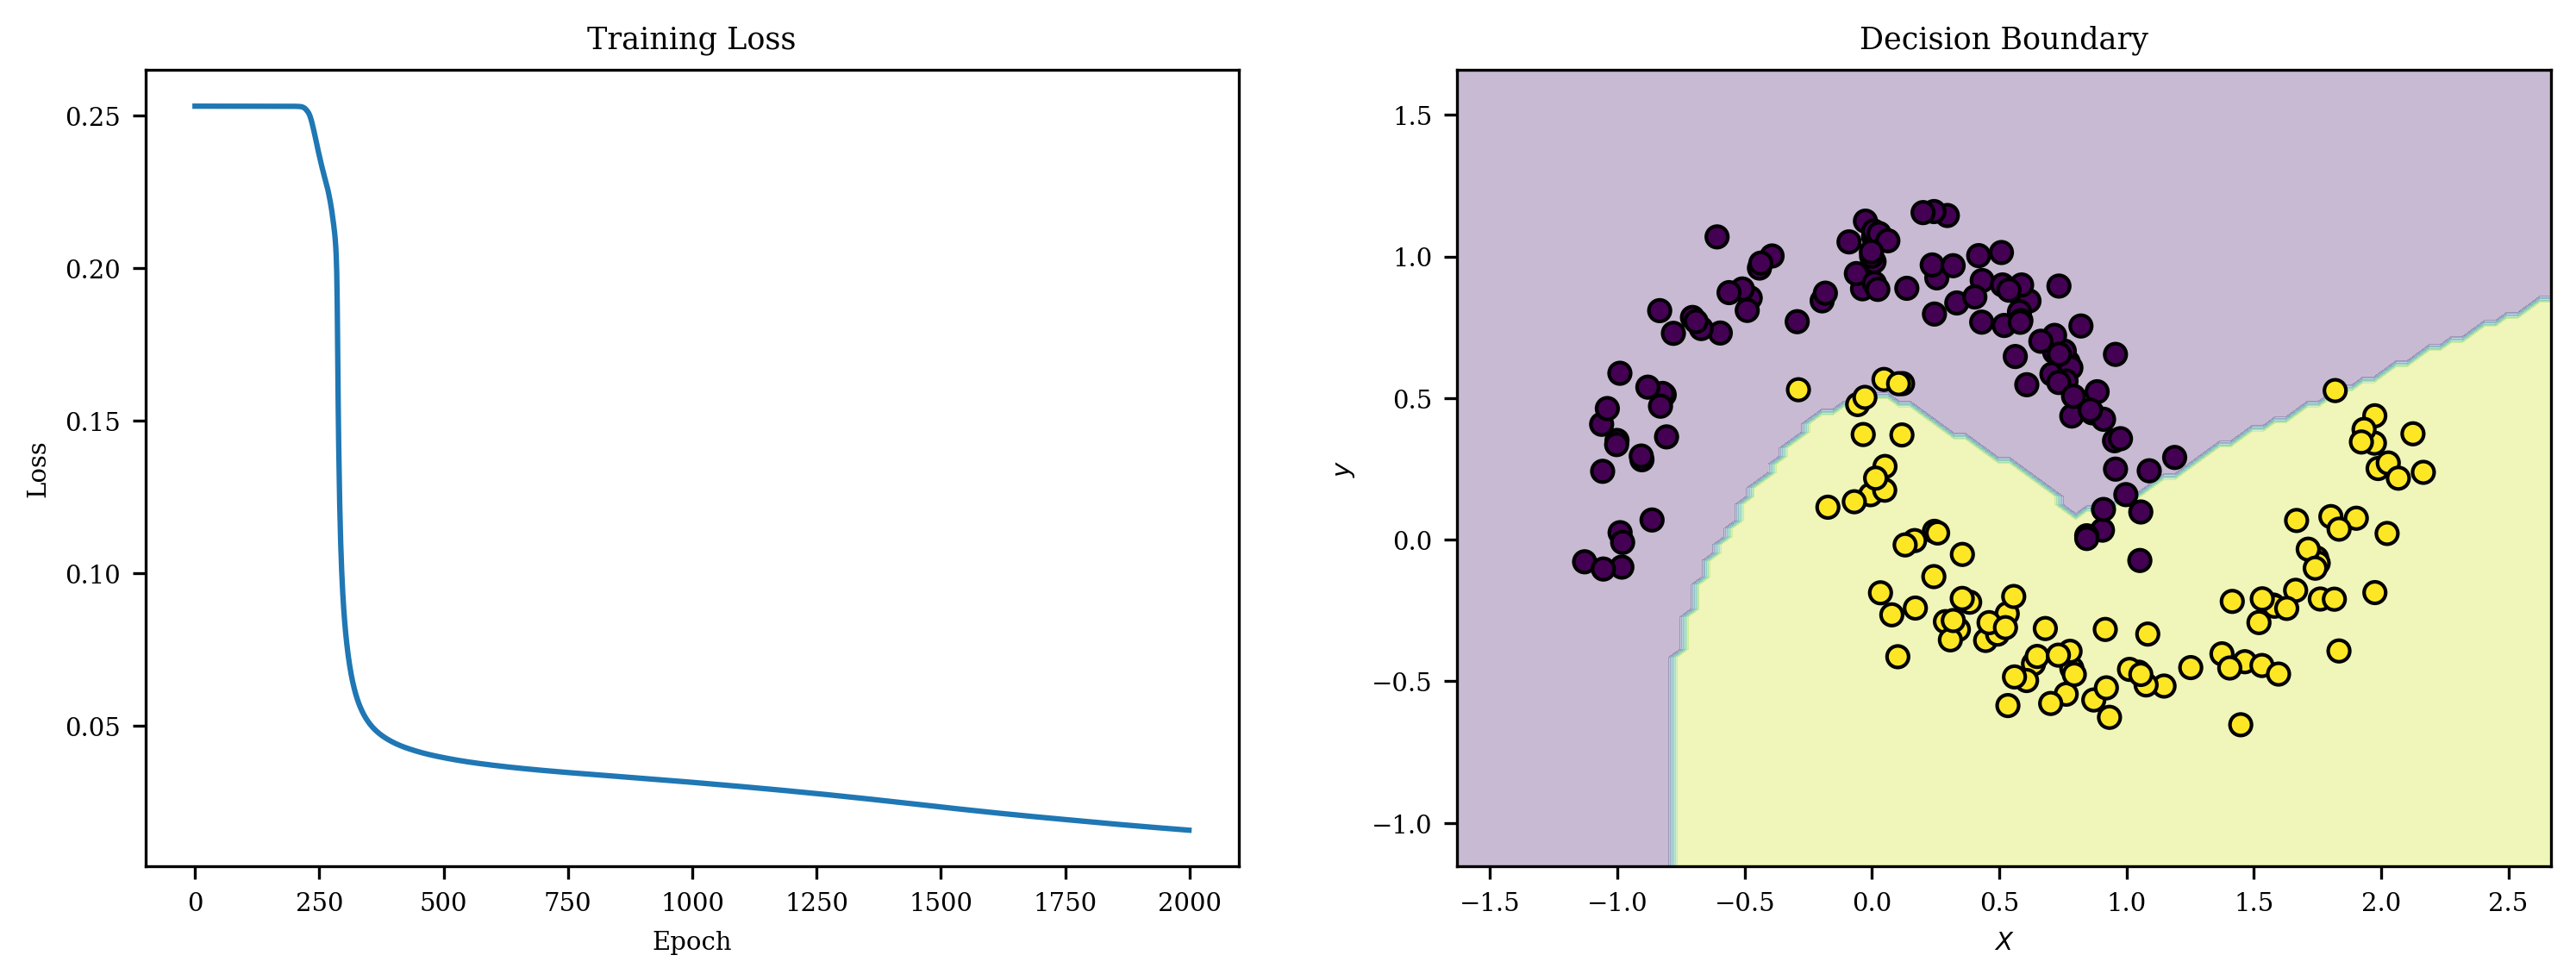

In [10]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Configure matplotlib for publication-quality plots
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 7
plt.rcParams["figure.dpi"] = 300

# Generate synthetic binary classification dataset
X_np, y_np = make_moons(n_samples=1000, noise=0.1, random_state=42)
X = jnp.array(X_np, dtype=jnp.float32)
y = jnp.array(y_np.reshape(-1, 1), dtype=jnp.float32)  # Ensure shape (n_samples, 1)


def split_data(key, X, y, train_ratio=0.8):
    """
    Split dataset into training and testing sets using JAX random sampling.

    Args:
        key: JAX random key
        X: Input features
        y: Target labels
        train_ratio: Fraction of data for training (default: 0.8)

    Returns:
        Tuple of (X_train, X_test, y_train, y_test)
    """
    n = X.shape[0]
    n_train = int(n * train_ratio)
    indices = jax.random.permutation(key, n)
    train_idx, test_idx = indices[:n_train], indices[n_train:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]


# Split data into train/test sets
key = jax.random.PRNGKey(42)
X_train, X_test, y_train, y_test = split_data(key, X, y)

# Initialize network architecture for binary classification
layer_sizes = [2, 16, 1]  # Input:2, Hidden:16, Output:1 (binary classification)
weights, biases = initialize_network(layer_sizes, key)

# Train the neural network
trained_weights, trained_biases, loss_history = train_network(
    weights,
    biases,
    X_train,
    y_train,
    epochs=2000,
    learning_rate=0.05,
    activation="relu",
    loss_type="mse",
    print_loss=False,
)


def predict(X, weights, biases):
    """
    Generate binary predictions using trained network.

    Args:
        X: Input features
        weights: Trained weight matrices
        biases: Trained bias vectors

    Returns:
        Binary predictions (0 or 1)
    """
    output, _ = forward_pass(X, weights, biases, activation="relu")
    return (output > 0.5).astype(jnp.float32)


def accuracy(y_true, y_pred):
    """
    Compute classification accuracy.

    Args:
        y_true: True labels
        y_pred: Predicted labels

    Returns:
        Accuracy score between 0 and 1
    """
    return jnp.mean(y_true == y_pred)


# Evaluate model performance
train_preds = predict(X_train, trained_weights, trained_biases)
test_preds = predict(X_test, trained_weights, trained_biases)

print(f"Train accuracy: {accuracy(y_train, train_preds):.2f}")
print(f"Test accuracy: {accuracy(y_test, test_preds):.2f}")


def plot_decision_boundary(X, y, weights, biases):
    """
    Visualize decision boundary and training progress.

    Args:
        X: Input features for plotting
        y: True labels for coloring points
        weights: Trained weight matrices
        biases: Trained bias vectors
    """
    # Create prediction grid for decision boundary visualization
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = jnp.meshgrid(
        jnp.linspace(x_min, x_max, 100), jnp.linspace(y_min, y_max, 100)
    )

    # Generate predictions on grid points
    grid = jnp.column_stack([xx.ravel(), yy.ravel()])
    Z = predict(grid, weights, biases)
    Z = Z.reshape(xx.shape)

    # Create visualization with training curve and decision boundary
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plot training loss curve
    axes[0].plot(jnp.array(loss_history))
    axes[0].set_title("Training Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")

    # Plot decision boundary with data points
    axes[1].contourf(xx, yy, Z, alpha=0.3)
    axes[1].scatter(X[:, 0], X[:, 1], c=y.ravel(), edgecolors="k")
    axes[1].set_title("Decision Boundary")
    axes[1].set_xlabel(r"$X$")
    axes[1].set_ylabel(r"$y$")

    plt.show()


# Visualize results
plot_decision_boundary(X_test, y_test, trained_weights, trained_biases)